In [13]:
import gym
import numpy as np
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
env = gym.make('Pong-v0')

In [50]:
EPISODES = 1000
GAMMA = 0.99

EXPLORE_INIT = 1.0
EXPLORE_FINAL = 0.01
EXPLORE_FINAL_FRAME = 100000

MEMORY_SIZE = 50000
MEMORT_START_SIZE = 1000

BATCH_SIZE = 16
ACTION_SIZE = env.action_space.n

Remove outer game area and normalize to 0-1

In [51]:
def preprocess(image):
    image = image / 255
    return image[34:194,0:160,0:3]

(160, 160, 3)


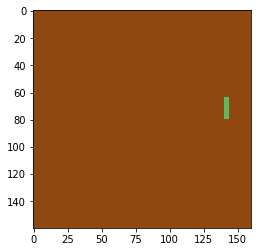

In [45]:
# env.reset()
# action = env.action_space.sample()
# obs, reward, done, _ = env.step(action)

# image = env.render(mode='rgb_array')
# image = image[34:194,0:160,0:3]
# image = image / 255
# print(image.shape)

# plt.imshow(image)

In [ ]:
class QNetwork:
    def __init__(self, learning_rate=0.001):
        self.model = Sequential()

        self.model.add(Dense(hidden_size, activation='relu',
                             input_dim=state_size))
        self.model.add(Dense(action_size, activation='linear'))

        self.optimizer = Adam(lr=learning_rate)
        self.model.compile(loss='mse', optimizer=self.optimizer)

In [52]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)
    
    def size(self):
        return len(self.buffer)

    def sample(self, batch_size):
        idx = np.random.choice(
            np.arange(len(self.buffer)),
            size=batch_size,
            replace=False
        )
        return [self.buffer[ii] for ii in idx]

In [49]:
memory = Memory(max_size = MEMORY_SIZE)

In [ ]:
explore_rate = EXPLORE_INIT
frame = 0

for ep in range(0, EPISODES):
    env.reset()
    state, reward, done, _ = env.step(env.action_space.sample())
    state = preprocess(state)
    frame += 1
    
    total_reward = 0
    
    while True:
        explore_rate = np.max(
            EXPLORE_FINAL, 
            EXPLORE_INIT - (EXPLORE_INIT - EXPLORE_FINAL) * frame / EXPLORE_FINAL_FRAME
        )
        
        if np.random.rand() > explore_rate:
            action = np.argmax(model.predict(state)[0])
        else:
            action = env.action_space.sample()
            
        
        next_state, reward, done, _ = env.step(env.action_space.sample())
        next_state = preprocess(next_state)
        frame += 1
        state = next_state
        
#         env.render()
        
        total_reward += reward
        
        memory.add((state, action, reward, done, next_state))
        
        if memory.size() >= MEMORT_START_SIZE:
            minibatch = memory.sample(BATCH_SIZE)
            
            inputs = np.zeros((BATCH_SIZE, 160, 160, 3))
            targets = np.zeros((BATCH_SIZE, ACTION_SIZE))
            
            for i, (state_b, action_b, reward_b, done_b, next_state_b) in enumerate(minibatch):
                inputs[i:i+1] = state_b
                if done_b:
                    target = reward_b
                else:
                    target = reward_b + GAMMA * np.amax(model.predict(next_state_b)[0])
                targets[i] = model.predict(state_b)
                targets[i][action_b] = target
                
            model.fit(inputs, targets, epochs=1, verbose=0)

        
        if done:
            print("Episode {}, Total Reward {}, Explore Rate {}".format(ep + 1, total_reward, explore_rate))
            break